In [255]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn import tree
from collections import defaultdict
import random
import pydot
from io import StringIO
import pydotplus

In [256]:
df = pd.read_csv('movie_metadata.csv')

In [257]:
df.columns

Index(['color', 'director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'genres', 'actor_1_name',
       'movie_title', 'num_voted_users', 'cast_total_facebook_likes',
       'actor_3_name', 'facenumber_in_poster', 'plot_keywords',
       'movie_imdb_link', 'num_user_for_reviews', 'language', 'country',
       'content_rating', 'budget', 'title_year', 'actor_2_facebook_likes',
       'imdb_score', 'aspect_ratio', 'movie_facebook_likes'],
      dtype='object')

In [258]:
print(df.isnull().sum()) # columns with missing data

color                         19
director_name                104
num_critic_for_reviews        50
duration                      15
director_facebook_likes      104
actor_3_facebook_likes        23
actor_2_name                  13
actor_1_facebook_likes         7
gross                        884
genres                         0
actor_1_name                   7
movie_title                    0
num_voted_users                0
cast_total_facebook_likes      0
actor_3_name                  23
facenumber_in_poster          13
plot_keywords                153
movie_imdb_link                0
num_user_for_reviews          21
language                      12
country                        5
content_rating               303
budget                       492
title_year                   108
actor_2_facebook_likes        13
imdb_score                     0
aspect_ratio                 329
movie_facebook_likes           0
dtype: int64


In [259]:
dataset = df[['gross', 'imdb_score', 'movie_title']]
print(dataset.isnull().sum())
dataset.dropna()
print(len(dataset))
dataset = dataset.values.tolist()

gross          884
imdb_score       0
movie_title      0
dtype: int64
5043


In [260]:
def kMedoids(data, k, prev_cost, count, clusters=None, medoids=None):

    cluster_sum = 0
    random.seed(0)

    while True:

        if medoids is None or not medoids:
            medoids = random.sample(data, k)
        else:
            random.shuffle(medoids)
            for _ in range(0, int(k/2)):
                medoids.pop()
            medoids += random.sample(data, int(k/2))

        clusters = defaultdict(list)

        for item in data:
            temp = []
            for i in range(0, len(medoids)):
                med = medoids[i]
                if med is None or not med:
                    break
                else:
                    temp.append(np.linalg.norm(
                        med[0]-item[0])+np.linalg.norm(med[1]-item[1]))
            min_index = np.argmin(temp)
            clusters[min_index].append(item)

        for i in range(0, len(medoids)):
            inter_cluster = clusters[i]
            for j in range(0, len(inter_cluster)):
                item_cluster = inter_cluster[j]
                medoid = medoids[i]
                cluster_sum += (np.linalg.norm(medoid[0]-item_cluster[0]) +
                                np.linalg.norm(medoid[1]-item_cluster[1]))

        if cluster_sum < prev_cost:
            prev_cost = cluster_sum
        else:
            break

        count += 1

    return clusters

In [261]:
clusters = kMedoids(dataset, 4, np.inf, 0)
for i in range(0,len(clusters)):
    print(str(i+1),len(clusters.get(i)))

1 1350
2 1299
3 1209
4 1185


No handles with labels found to put in legend.


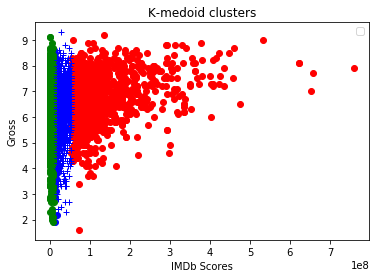

In [262]:
def plot_graph(clusters):
    markers = ['bo', 'go', 'ro', 'b+', 'r+', 'g+']
    for i in range(0, len(clusters.keys())):
        data = clusters.get(i)
        for j in range(0, len(data)):
            df = data[j]
            plt.plot(df[0], df[1], markers[i])
    plt.xlabel('IMDb Scores')
    plt.ylabel('Gross')
    plt.title('K-medoid clusters')
    plt.legend()
    plt.show()

plot_graph(clusters)

In [263]:
columns = ['num_user_for_reviews', 'budget'
               , 'num_critic_for_reviews', 'movie_title']

df = df[columns].dropna()
print(df.isnull().sum())
print(len(df))

num_user_for_reviews      0
budget                    0
num_critic_for_reviews    0
movie_title               0
dtype: int64
4520


In [264]:
def assign_target(row, clusters):

    x = row['movie_title']

    for i in range(0, len(clusters.keys())):
        data = clusters.get(i)
        for j in range(0, len(data)):
            df = data[j]
            if df[2] == x:
                row['cluster'] = 'cluster'+str(i)

    return row

In [265]:
df = df.reset_index()
df = df.apply(assign_target, args=(clusters,), axis=1)
df.drop(labels = ['movie_title'], axis = 1, inplace = True)
print(df.tail())

      index  num_user_for_reviews  budget  num_critic_for_reviews   cluster
4515   5034                  35.0  7000.0                    35.0  cluster1
4516   5035                 130.0  7000.0                    56.0  cluster1
4517   5037                  14.0  9000.0                    14.0  cluster1
4518   5040                   3.0  1400.0                    13.0  cluster0
4519   5042                  84.0  1100.0                    43.0  cluster1


In [266]:
df_before_split = df.copy()
print(df.head())
splitSet = StratifiedShuffleSplit(
        n_splits=1, test_size=0.2, random_state=0)

for train_index, test_index in splitSet.split(df, df['cluster']):
    train_set = df.loc[train_index]
    test_set = df.loc[test_index]

Y_train = train_set.cluster
X_train = train_set[train_set.columns.drop('cluster').drop('index')]
Y_test = test_set.cluster
X_test = test_set[test_set.columns.drop('cluster').drop('index')]

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)

predictions = decision_tree.predict(X_test)

   index  num_user_for_reviews       budget  num_critic_for_reviews   cluster
0      0                3054.0  237000000.0                   723.0  cluster2
1      1                1238.0  300000000.0                   302.0  cluster2
2      2                 994.0  245000000.0                   602.0  cluster2
3      3                2701.0  250000000.0                   813.0  cluster2
4      5                 738.0  263700000.0                   462.0  cluster2


In [267]:
print('Accuracy', decision_tree.score(X_test, Y_test))

Accuracy 0.4491150442477876


In [268]:
print(confusion_matrix(Y_test,predictions))
print('\n')
print(classification_report(Y_test,predictions))

[[ 82  77  24  31]
 [ 66  99  18  38]
 [ 29  20 134  56]
 [ 34  39  66  91]]


             precision    recall  f1-score   support

   cluster0       0.39      0.38      0.39       214
   cluster1       0.42      0.45      0.43       221
   cluster2       0.55      0.56      0.56       239
   cluster3       0.42      0.40      0.41       230

avg / total       0.45      0.45      0.45       904



In [269]:
rfc = RandomForestClassifier(n_estimators=2000)
rfc.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [270]:
rfc_pred = rfc.predict(X_test)
print(confusion_matrix(Y_test,rfc_pred))
print('\n')
print(classification_report(Y_test,rfc_pred))

[[ 82  80  15  37]
 [ 57 109  11  44]
 [ 13  12 159  55]
 [ 28  46  56 100]]


             precision    recall  f1-score   support

   cluster0       0.46      0.38      0.42       214
   cluster1       0.44      0.49      0.47       221
   cluster2       0.66      0.67      0.66       239
   cluster3       0.42      0.43      0.43       230

avg / total       0.50      0.50      0.50       904



In [271]:
dot_data = StringIO()
export_graphviz(decision_tree, out_file=dot_data,
                    filled=True, rounded=True,
                    special_characters=True, impurity=False, feature_names=train_set.columns.drop('cluster').drop('index'))
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png("dtree.png")

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.322174 to fit



True